In [1]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.statespace.varmax import VARMAX
# from statsmodels.tsa.api import VAR
# from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('AirQuality.csv',sep=";",parse_dates=[['Date', 'Time']],decimal=',',na_values=-200,na_filter=True)
data.drop(["Unnamed: 15","Unnamed: 16"],axis = 1,inplace = True)

data.fillna(method='ffill',inplace=True)
data.drop_duplicates(inplace=True)

data.drop(9357,inplace = True)
data['Date_Time'] = pd.to_datetime(data['Date_Time'],format="%d/%m/%Y %H.%M.%S")

In [3]:
d_r = data.set_index('Date_Time')

In [4]:
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(d_r['CO(GT)'].iloc[6:6+2*168])

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis.\n Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root,\n indicating it is non-stationary ")


In [5]:
adfuller_test(d_r['CO(GT)'].iloc[6:6+2*168])

ADF Test Statistic : -8.056121078605194
p-value : 1.6907445445696093e-12
#Lags Used : 5
Number of Observations Used : 330
strong evidence against the null hypothesis(Ho), reject the null hypothesis.
 Data has no unit root and is stationary


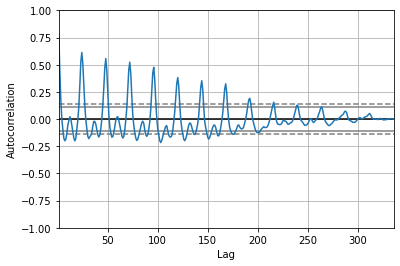

In [6]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(d_r['CO(GT)'].iloc[6:6+2*168])
plt.show()

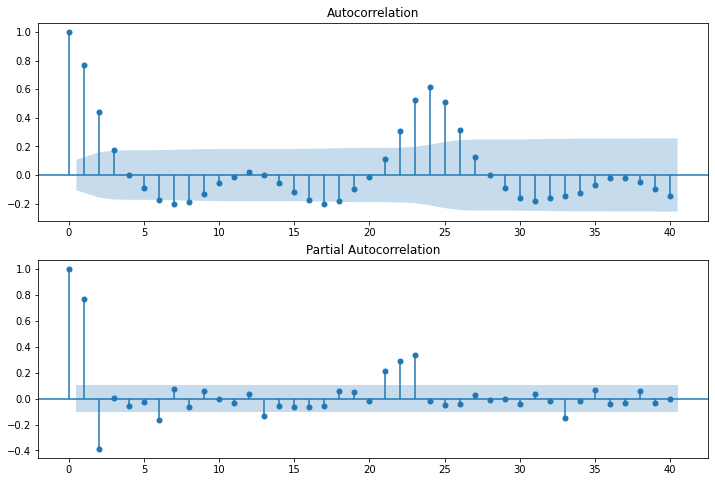

In [7]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(d_r['CO(GT)'].iloc[6:6+2*168],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(d_r['CO(GT)'].iloc[6:6+2*168],lags=40,ax=ax2)

In [8]:
p = 3;q = 3; d = 1 # try d with 0, 1

In [9]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(d_r['CO(GT)'].iloc[6:6+15],order=(p, d, q),seasonal_order=(p,d,q,365))
results=model.fit(low_memory=True,maxiter=1)

KeyboardInterrupt: 

In [10]:
def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

In [11]:
d_r.set_index(add_freq(d_r.index),inplace= True)

In [12]:
train_data = d_r[['CO(GT)','T']].iloc[6:6+168]
test_data = d_r[['CO(GT)','T']].iloc[6+168:6+2*168]

In [5]:
import sktime

In [32]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(
    use_box_cox=True,
    use_trend=True,
    use_damped_trend=True,
    sp=24,
    use_arma_errors=True,
    n_jobs=-1)


In [66]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(d_r['CO(GT)'].iloc[6+7*24:6+8*24].index,is_relative=False)

In [67]:
forecaster.fit(y=d_r['CO(GT)'].iloc[6:6+168])
future = forecaster.predict(fh=fh)

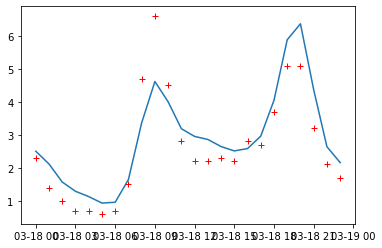

In [68]:
plt.plot(future)
plt.plot(d_r['CO(GT)'].iloc[6+7*24:6+8*24],'r+')

In [71]:
future.values

array([2.5036656 , 2.11445357, 1.56724121, 1.28666911, 1.12541119,
       0.92923085, 0.95390976, 1.64397163, 3.36241749, 4.61947902,
       4.00352059, 3.18662664, 2.95251119, 2.86030468, 2.64521295,
       2.51219406, 2.58326819, 2.96065696, 4.05005549, 5.8864901 ,
       6.37122373, 4.36849748, 2.64001836, 2.15818632])

In [88]:
future_l = list(future.values)

In [89]:
future_l = [future_l]
for i in range(8,14):
    fh1 = ForecastingHorizon(d_r['CO(GT)'].iloc[6+i*24:6+(i+1)*24].index,is_relative=False)
    future1 = forecaster.update_predict_single(d_r['CO(GT)'].iloc[6+(i-1)*24:6+i*24],fh=fh1,update_params=True) 
    future_l.append(list(future.to_numpy()))#future1)
    

<AxesSubplot:xlabel='Date_Time'>

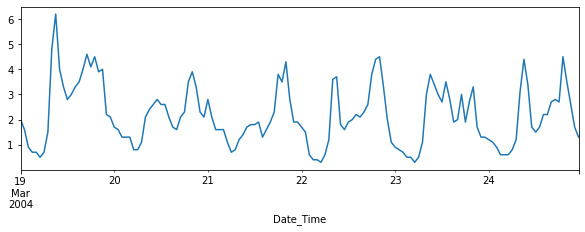

In [39]:
d_r['CO(GT)'].iloc[6+8*24:6+(13+1)*24].plot(figsize = (10,3))

In [46]:
np.array(future_l).shape

(6,)

In [90]:
for i in future_l:
    try:
        assert len(i) == 24
        print("[INFO] passed")
    except:
        print(f"{i}")

[INFO] passed
[INFO] passed
[INFO] passed
[INFO] passed
[INFO] passed
[INFO] passed
[INFO] passed


In [74]:
fh1 = ForecastingHorizon(d_r['CO(GT)'].iloc[6+216:6+2*168].index,is_relative=False) 

In [75]:
future1 = forecaster.update_predict_single(d_r['CO(GT)'].iloc[6+192:6+216],fh=fh1,update_params=True)

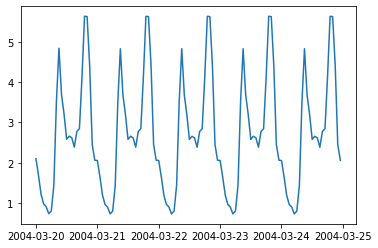

In [76]:
plt.plot(future1)

In [78]:
len(future_l[0]+future_l[1])

48

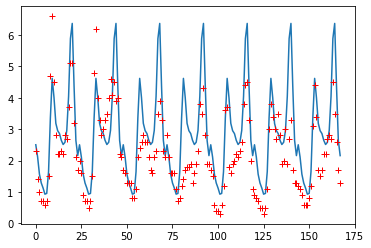

In [93]:
t = future_l[0]
for i in range(1,len(future_l)):
    t = t+future_l[i]
assert len(t)==168, f"len is : {len(t)}"
plt.plot(t)
plt.plot(d_r['CO(GT)'].iloc[6+168:6+2*168].values,'r+')

In [47]:
from sklearn.metrics import mean_absolute_percentage_error
def test_model_mape(preds,actual,start=8):
  l_mape = []
  for i,pred in enumerate(preds):
    mape = mean_absolute_percentage_error(pred,actual.iloc[(start+i)*24+6:(start+i+1)*24+6].to_numpy())
    print(f"{i}) MAPE : {mape} ")
    l_mape.append(mape) 
  return np.mean(l_mape)

In [91]:
test_model_mape(future_l,d_r['CO(GT)'],7)

0) MAPE : 0.2254754801043126 
1) MAPE : 0.2534624721646063 
2) MAPE : 0.24567967033405905 
3) MAPE : 0.32340945923301007 
4) MAPE : 0.3335450712166627 
5) MAPE : 0.37007458282478806 
6) MAPE : 0.30929219078728465 


0.29441984666638904

In [95]:
import pickle

file_name = "TBATS_online_0_2944.pkl"
pickle.dump(forecaster,open(file_name,'wb'))

In [96]:
test_model = pickle.load(open(file_name,'rb'))

In [97]:
test_model

TBATS(n_jobs=-1, sp=24, use_box_cox=True, use_damped_trend=True, use_trend=True)

In [145]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

In [148]:
def m(class_name):
    forecaster_t = TBATS(
        use_box_cox=True,
        use_trend=True,
        use_damped_trend=True,
        sp=24,
        use_arma_errors=True,
        n_jobs=-1)
    
    fh = ForecastingHorizon(d_r[class_name].iloc[6+7*24:6+8*24].index,is_relative=False)
    
    forecaster.fit(y=d_r[class_name].iloc[6:6+168])
    future = forecaster.predict(fh=fh)
    
    future_l = list(future.values)
    future_l = [future_l]
    for i in range(8,14):
        fh1 = ForecastingHorizon(d_r[class_name].iloc[6+i*24:6+(i+1)*24].index,is_relative=False)
        future1 = forecaster.update_predict(y=d_r[class_name].iloc[6+(i-1)*24:6+i*24],update_params=True,fh=fh1,) 
        future_l.append(list(future.to_numpy()))#future1)
    
    for i in future_l:
        try:
            assert len(i) == 24
            print("[INFO] passed")
        except:
            print(f"{i}")
            
    print(test_model_mape(preds,d_r[class_name]))
    return forecaster_t, future_l
    
    
    

In [135]:
trained_model, preds = m('T')

[INFO] passed
[INFO] passed
[INFO] passed
[INFO] passed
[INFO] passed
[INFO] passed
[INFO] passed


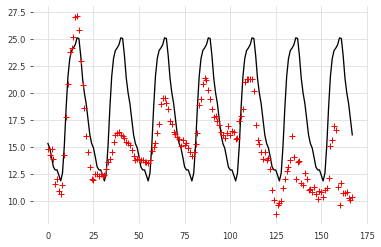

In [136]:
t = preds[0]
for i in range(1,len(preds)):
    t = t+preds[i]
assert len(t)==168, f"len is : {len(t)}"
plt.plot(t)
plt.plot(d_r['T'].iloc[6+168:6+2*168].values,'r+')

In [137]:
test_model_mape(preds,d_r['T'])

0) MAPE : 0.1985839236698512 
1) MAPE : 0.14308714719617463 
2) MAPE : 0.12555856534225102 
3) MAPE : 0.1852899841161618 
4) MAPE : 0.30906397106581435 
5) MAPE : 0.3312316204393503 
6) MAPE : 0.3573996218472952 


0.23574497623955692

In [149]:
file_name = 'TBATS_online_0_2357.pkl'
pickle.dump(trained_model,open(file_name,'wb'))

In [150]:
test_model = pickle.load(open(file_name,'rb'))
test_model

TBATS(n_jobs=-1, sp=24, use_box_cox=True, use_damped_trend=True, use_trend=True)

### NBEATS starts here

In [101]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller

In [129]:
model_nbeats = NBEATSModel(
    input_chunk_length=72,
    output_chunk_length=24,
    generic_architecture=True,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=1,
    model_name="nbeats_interpretable_run",
)

In [107]:
series=TimeSeries.from_dataframe(data.iloc[6:6+168],time_col='Date_Time',value_cols='CO(GT)')

In [108]:
val_series=TimeSeries.from_dataframe(data.iloc[6+168:6+2*168],time_col='Date_Time',value_cols='CO(GT)')

In [130]:
model_nbeats.fit(series=series,verbose=True)#,val_series=val_series , verbose=True)

[2022-01-30 19:07:58,112] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-01-30 19:07:58,112] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-01-30 19:07:58,748] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-30 19:07:58,748] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [131]:
nbeats_preds = model_nbeats.predict(168,verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]

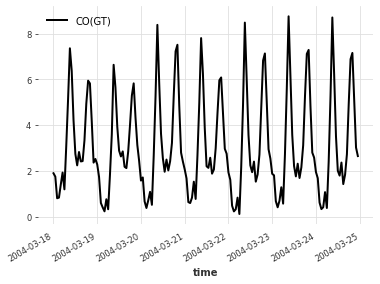

In [133]:
nbeats_preds.plot()

In [121]:
nbeats_preds.values().squeeze()

array([ 0.378215  ,  1.03667474,  1.63967154,  2.18719755,  2.67927631,
        3.11589267,  3.49701365,  3.82273537,  4.09293055,  4.30763611,
        4.46699694,  4.57086581,  4.61914654,  4.6120824 ,  4.54957191,
        4.43144444,  4.25801781,  4.02912848,  3.74455925,  3.40476282,
        3.00948531,  2.55872453,  2.05250103,  1.490548  ,  0.70962754,
        1.08636116,  1.43684359,  1.76106714,  2.05905487,  2.33079212,
        2.57624603,  2.79551154,  2.98846312,  3.15513428,  3.29567697,
        3.40993626,  3.49782168,  3.55957541,  3.59508727,  3.60420371,
        3.58722241,  3.54398718,  3.47429461,  3.37859598,  3.25660749,
        3.10835475,  2.93385092,  2.73284094,  0.66004883,  1.2684344 ,
        1.82418696,  2.32729855,  2.77779309,  3.1756551 ,  3.5208513 ,
        3.81347907,  4.05340934,  4.24068176,  4.3754365 ,  4.45753132,
        4.4868659 ,  4.46368496,  4.38789262,  4.25930625,  4.07825784,
        3.84457879,  3.55804199,  3.2191022 ,  2.82752476,  2.38

In [ ]:
plt.plot(nbeats_preds.values().squeeze())
plt.plot(d_r['CO(GT)'].iloc[6+168:6+2*168].values,'r+')

In [124]:
print(f"NBEATS MAPE : {mean_absolute_percentage_error(nbeats_preds.values().squeeze(),d_r['CO(GT)'].iloc[6+168:6+2*168])}")

NBEATS MAPE : 0.9243507625617562


In [80]:
from sklearn.metrics import mean_absolute_percentage_error

print(f"MAPE : {mean_absolute_percentage_error(future,d_r['CO(GT)'].iloc[6+168:6+2*168])}")

MAPE : 0.28691783386235314


In [39]:
d_r.index[6+15:6+20]

DatetimeIndex(['2004-03-11 15:00:00', '2004-03-11 16:00:00',
               '2004-03-11 17:00:00', '2004-03-11 18:00:00',
               '2004-03-11 19:00:00'],
              dtype='datetime64[ns]', name='Date_Time', freq='H')

In [27]:
datetime_series = pd.Series(
     pd.date_range("2004-03-11 15:00:00", periods=5, freq="h")
)

In [28]:
datetime_series

0   2004-03-11 15:00:00
1   2004-03-11 16:00:00
2   2004-03-11 17:00:00
3   2004-03-11 18:00:00
4   2004-03-11 19:00:00
dtype: datetime64[ns]

In [ ]:
forecaster.predict(fh = d_r.index[6+15:6+20],X=d_r['CO(GT)'].iloc[6:6+15])

In [99]:
!pip install darts

     |████████████████████████████████| 326 kB 556 kB/s eta 0:00:01
     |████████████████████████████████| 65 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 845 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 39.1 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 165 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 6.0 MB/s eta 0:00:011
     |████████████████████████████████| 5.4 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 3.9 MB/s eta 0:00:011
     |████████████████████████████████| 46 kB 3.8 MB/s eta 0:00:011
     |████████████████████████████████| 1.4 MB 1.6 MB/s eta 0:00:01


     |████████████████████████████████| 233 kB 2.4 MB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /Users/kishorekunisetty/opt/anaconda3/envs/hack/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/xk/gskgc70x7zz8xbpr5p918gjh0000gn/T/pip-install-690pd5kl/prophet_1cedaa980bb141548ec7efbcf13b8365/setup.py'"'"'; __file__='"'"'/private/var/folders/xk/gskgc70x7zz8xbpr5p918gjh0000gn/T/pip-install-690pd5kl/prophet_1cedaa980bb141548ec7efbcf13b8365/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/xk/gskgc70x7zz8xbpr5p918gjh0000gn/T/pip-wheel-fd9cknvs
       cwd: /private/var/folders/xk/gskgc70x7zz8xbpr5p918gjh0000gn/T/pip-install-690pd5kl/prophet_1cedaa980bb141548ec7efbcf13b8365/
  Complete output (44 lines):
  running bdist_wheel
  running build
  running build_py


  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730973 sha256=d73e1d57e91c8bceb0eaa8f782a3059ac153524d9ed122ebcdac29074c0dd285
  Stored in directory: /Users/kishorekunisetty/Library/Caches/pip/wheels/33/6b/a6/1d9dae2323750f635654952afc74aa8f2d982cded163f43895
Successfully built pymeeus
Failed to build prophet
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
    Running setup.py install for prophet ... done
  DEPRECATION: prophet was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
ERROR: pip'